In [1]:
#!pip install -q -q -q geopandas
#!pip install -q -q -q contextily

In this notebook, we describe the sandbox analysis of spatial distribution of buildings.

In [2]:
import numpy as np
import pandas as pd

import geopandas as gpd
#import contextily as ctx
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KDTree

Load the built-up areas

In [3]:
bocage = pd.read_csv('bocage_ign_2012.csv')
openfield = pd.read_csv('openfield_ign_2012.csv')

Display the two spatial distributions of building :

In [4]:
s_bocage = gpd.GeoDataFrame(bocage, geometry=gpd.points_from_xy(bocage.x, bocage.y), crs='EPSG:2154')
s_openfield = gpd.GeoDataFrame(openfield, geometry=gpd.points_from_xy(openfield.x, openfield.y), crs='EPSG:2154')

First of all, we have to calculate the neigbhors near each building for several radius.

In [5]:
def neighbors_near_point(df, list_of_radius):
    neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)
    for i, r in enumerate(list_of_radius):
        tree = KDTree(df[['x', 'y']]) 
        neighbors[:,i] = tree.query_radius(df[['x', 'y']], r= r, count_only=True)
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    return(result)

In [6]:
radius_range = np.array([50, 100, 200, 400, 800])
bocage_neighbor = neighbors_near_point(bocage, radius_range)
openfield_neighbor = neighbors_near_point(openfield, radius_range)

C:\Users\FRANCO~1.SEM\AppData\Local\Temp/ipykernel_18132/1271688115.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)
C:\Users\FRANCO~1.SEM\AppData\Local\Temp/ipykernel_18132/1271688115.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighbors = np.zeros([df.shap

Now, we can compute the generalized dimensions.

In [7]:
def entropy(neighbor,q):
    if q!=1:
        return(np.log2(np.sum(neighbor**(q-1)))/(q-1))
    else:
        return(np.sum(np.log2(neighbor)) /neighbor.shape[0] )

def scale_function(neighbor, list_of_q):
    resultat = []
    for q in list_of_q:
        resultat.append(entropy(neighbor, q))   
    result = pd.concat(resultat, axis=1)
    result = result.transpose()
    result['q'] = list_of_q
    return(result)

In [8]:
bocage_neighbor

,50,100,200,400,800
0,2.0,3.0,4.0,8.0,94.0
1,1.0,1.0,8.0,24.0,105.0
2,4.0,9.0,12.0,38.0,73.0
3,4.0,8.0,25.0,55.0,109.0
4,9.0,31.0,108.0,335.0,969.0
...,...,...,...,...,...
52171,6.0,21.0,68.0,201.0,769.0
52172,6.0,24.0,84.0,142.0,211.0
52173,3.0,14.0,56.0,127.0,191.0
52174,3.0,12.0,42.0,82.0,204.0


First, we calculate the generalized dimension for the scale range (radius) 50 - 800 m

In [9]:
list_of_radius = np.array([50, 100,  200, 400, 800])

In [10]:
bocage_scaling = scale_function(bocage_neighbor, np.arange(-5,5.5,0.5))
bocage_scaling['Dq'] = bocage_scaling[list_of_radius.astype(str)].apply(lambda x :LinearRegression().fit(np.log2(list_of_radius).reshape(list_of_radius.size,1), x).coef_[0] , axis=1 )  
openfield_scaling = scale_function(openfield_neighbor, np.arange(-5,5.5,0.5))
openfield_scaling['Dq'] = openfield_scaling[list_of_radius.astype(str)].apply(lambda x :LinearRegression().fit(np.log2(list_of_radius).reshape(list_of_radius.size,1), x).coef_[0] , axis=1 )  

In [11]:
bocage_scaling[bocage_scaling.q==0] 

,50,100,200,400,800,q,Dq
10,-14.169293,-13.14049,-12.19552,-10.86131,-8.982575,0.0,1.265262


In [12]:
openfield_scaling[openfield_scaling.q==0] 

,50,100,200,400,800,q,Dq
10,-13.07839,-11.750958,-10.559997,-9.399287,-8.122739,0.0,1.226297


In [13]:
openfield_scaling = openfield_scaling[openfield_scaling.q==0] [['50', '100', '200', '400', '800']].values.flatten()
bocage_scaling = bocage_scaling[bocage_scaling.q==0] [['50', '100', '200', '400', '800']].values.flatten()
bocage_scaling = pd.DataFrame({'radius':list_of_radius, 'Iq' : bocage_scaling, 'configuration':'Bocage'})
openfield_scaling = pd.DataFrame({'radius':list_of_radius, 'Iq' : openfield_scaling, 'configuration':'Openfield'})

In [14]:
scaling = pd.concat([bocage_scaling, openfield_scaling])

In [15]:
openfield_scaling['Eq'] = 2**(openfield_scaling.Iq)
bocage_scaling['Eq'] = 2**(bocage_scaling.Iq)

In [16]:
d = np.polyfit(np.log2(openfield_scaling['radius']),openfield_scaling['Iq'],1)
f = np.poly1d(d)
openfield_scaling['line'] = 2**(f(np.log2(openfield_scaling['radius'])))

d = np.polyfit(np.log2(bocage_scaling['radius']),bocage_scaling['Iq'],1)
f = np.poly1d(d)
bocage_scaling['line'] = 2**(f(np.log2(bocage_scaling['radius'])))

In [17]:
bocage

,x,y,geometry
0,372429.338625,6.889692e+06,POINT (372429.339 6889692.480)
1,374231.481684,6.895974e+06,POINT (374231.482 6895973.851)
2,374200.719452,6.896474e+06,POINT (374200.719 6896473.663)
3,373510.600835,6.897412e+06,POINT (373510.601 6897411.666)
4,375288.234111,6.892853e+06,POINT (375288.234 6892853.239)
...,...,...,...
52171,375128.573035,6.892089e+06,POINT (375128.573 6892089.382)
52172,372712.002403,6.890812e+06,POINT (372712.002 6890811.857)
52173,373157.725598,6.888533e+06,POINT (373157.726 6888533.225)
52174,373345.917076,6.886369e+06,POINT (373345.917 6886369.018)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


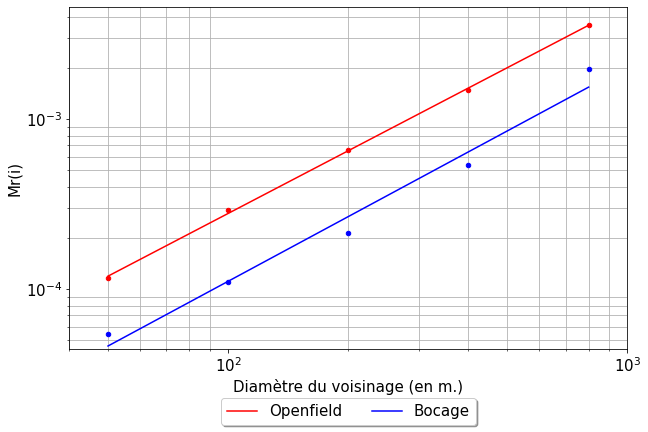

In [18]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)
plt.rcParams['axes.axisbelow'] = True

ax = openfield_scaling.plot.scatter('radius','Eq', loglog=True, figsize=(10,7), c='red')
bocage_scaling.plot.scatter('radius','Eq', loglog=True, figsize=(10,7), c='blue', ax=ax)
ax.set_xlim((40,1000))
ax.set_ylim((bocage_scaling.Eq.min()-0.00001, openfield_scaling.Eq.max()+0.001))
plt.grid(which='both')
openfield_scaling.plot.line('radius', 'line',color='Red',ax=ax, legend=False, label='Openfield')
bocage_scaling.plot.line('radius', 'line',color='blue',ax=ax, legend=False, label ='Bocage')
ax.set_xlabel('Diamètre du voisinage (en m.)')
ax.set_ylabel('Mr(i)')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.12),
          fancybox=True, shadow=True, ncol=5)

plt.savefig('figure7_2.pdf', format='pdf')

In [19]:
r = np.array([50, 100, 200, 400, 800])


In [20]:
logr = np.log2(r)
mat = np.array([[1,1,1,1,1] ,logr, logr**2]).T
ormat = np.linalg.qr(mat)[0]
ormat

array([[-4.47213595e-01, -6.32455532e-01,  5.34522484e-01],
       [-4.47213595e-01, -3.16227766e-01, -2.67261242e-01],
       [-4.47213595e-01, -5.55111512e-17, -5.34522484e-01],
       [-4.47213595e-01,  3.16227766e-01, -2.67261242e-01],
       [-4.47213595e-01,  6.32455532e-01,  5.34522484e-01]])

In [21]:
P1 = (logr - np.mean(logr))
P2 = (ormat[:,2] / np.std(ormat[:,2]) * 4/np.sqrt(5))

In [22]:
P2

array([ 2.13808994, -1.06904497, -2.13808994, -1.06904497,  2.13808994])

In [23]:
polynome = pd.DataFrame({'r':r, 'P1': P1, 'P2':P2})
polynome['logr'] = logr

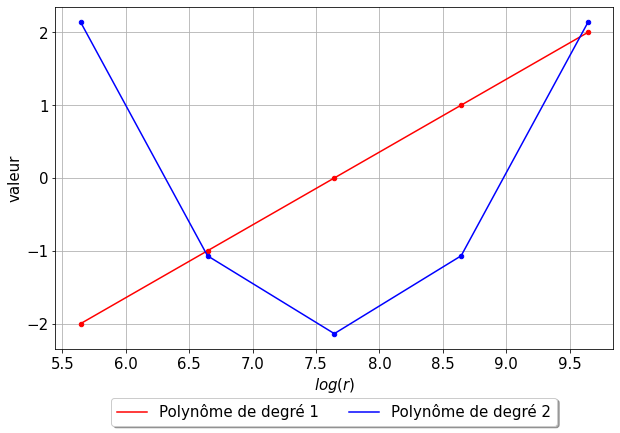

In [24]:
ax=polynome.plot.scatter('logr', 'P1', c='red', figsize=(10,7))
polynome.plot.line('logr','P1', color='red', ax=ax, label='Polynôme de degré 1')
polynome.plot.scatter('logr', 'P2', c='blue', ax=ax)
polynome.plot.line('logr','P2', color='blue', ax=ax, label='Polynôme de degré 2')
plt.grid(which='both')
ax.set_ylabel('valeur')
ax.set_xlabel('$log(r)$')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.12),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('figure7_10a.pdf', format='pdf')

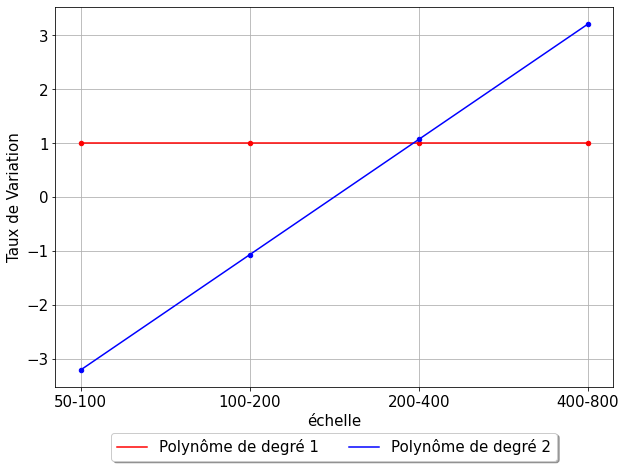

In [25]:
derive = pd.DataFrame({"derive1" : P1[1:] - P1[:4],"derive2" : P2[1:] - P2[:4], 'échelle':['50-100', '100-200', '200-400', '400-800']})
ax = derive.plot.scatter('échelle','derive1', figsize=(10,7), c='red')
derive.plot.scatter('échelle','derive2', c='blue', ax=ax)

derive.plot.line('échelle','derive1',ax=ax, legend=False, label='Polynôme de degré 1', color='red')
derive.plot.line('échelle','derive2',color='blue',ax=ax, legend=False, label ='Polynôme de degré 2')
plt.legend( loc='lower right', borderaxespad=0.)
plt.grid(which='both')
ax.set_ylabel('Taux de Variation')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.1),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('figure7_10b.pdf', format='pdf')


In [26]:
print(np.log2(openfield_scaling.Eq))
openfield_scaling

0   -13.078390
1   -11.750958
2   -10.559997
3    -9.399287
4    -8.122739
Name: Eq, dtype: float64


,radius,Iq,configuration,Eq,line
0,50,-13.078390,Openfield,0.000116,0.000119
1,100,-11.750958,Openfield,0.000290,0.000279
2,200,-10.559997,Openfield,0.000662,0.000652
3,400,-9.399287,Openfield,0.001481,0.001526
4,800,-8.122739,Openfield,0.003588,0.003570


In [27]:
fd = (np.log2(bocage_scaling.Eq[1:]).to_numpy() - np.log2(bocage_scaling.Eq[:4]).to_numpy()) 
fd_bocage = pd.DataFrame({'Taux de Variation': fd, 'échelle': ['50-100', '100-200', '200-400', '400-800']})
fd_bocage['territoire'] = 'Bocage'
fd = (np.log2(openfield_scaling.Eq[1:]).to_numpy() - np.log2(openfield_scaling.Eq[:4]).to_numpy()) 
fd_openfield = pd.DataFrame({'Taux de Variation': fd, 'échelle': ['50-100', '100-200', '200-400', '400-800']})
fd_openfield['territoire'] = 'Openfield'
fd = pd.concat([fd_bocage,fd_openfield])

In [28]:
fd_openfield

,Taux de Variation,échelle,territoire
0,1.327433,50-100,Openfield
1,1.190960,100-200,Openfield
2,1.160710,200-400,Openfield
3,1.276548,400-800,Openfield


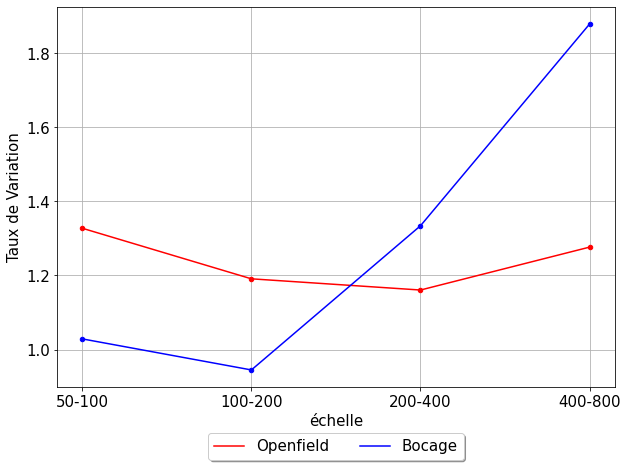

In [29]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}



matplotlib.rc('font', **font)
ax = fd_openfield.plot.scatter('échelle','Taux de Variation', figsize=(10,7), c='red')
fd_bocage.plot.scatter('échelle','Taux de Variation', c='blue', ax=ax)

fd_openfield.plot.line('échelle','Taux de Variation',ax=ax, legend=False, label='Openfield', color='red')
fd_bocage.plot.line('échelle','Taux de Variation',color='blue',ax=ax, legend=False, label ='Bocage')
plt.legend( loc='lower right', borderaxespad=0.)
plt.grid(which='both')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.1),
          fancybox=True, shadow=True, ncol=5)

plt.savefig('figure7_4.pdf', format='pdf')

In [30]:
from scipy import stats

In [31]:
openfield_scaling

,radius,Iq,configuration,Eq,line
0,50,-13.078390,Openfield,0.000116,0.000119
1,100,-11.750958,Openfield,0.000290,0.000279
2,200,-10.559997,Openfield,0.000662,0.000652
3,400,-9.399287,Openfield,0.001481,0.001526
4,800,-8.122739,Openfield,0.003588,0.003570


In [32]:
d = np.polyfit(np.log2(bocage_scaling['radius']),bocage_scaling['Iq'],1)
f = np.poly1d(d)
toto = f(np.log2(bocage_scaling['radius']))
fd_bocage['P1'] = toto[1:] - toto[:4] 
d = np.polyfit(np.log2(bocage_scaling['radius']),bocage_scaling['Iq'],2)
f = np.poly1d(d)
toto = f(np.log2(bocage_scaling['radius']))
fd_bocage['P2'] = toto[1:] - toto[:4] 



In [33]:
d = np.polyfit(np.log2(openfield_scaling['radius']),openfield_scaling['Iq'],1)
f = np.poly1d(d)
toto = f(np.log2(openfield_scaling['radius']))
fd_openfield['P1'] = toto[1:] - toto[:4] 
d = np.polyfit(np.log2(openfield_scaling['radius']),openfield_scaling['Iq'],2)
f = np.poly1d(d)
toto = f(np.log2(openfield_scaling['radius']))
fd_openfield['P2'] = toto[1:] - toto[:4] 


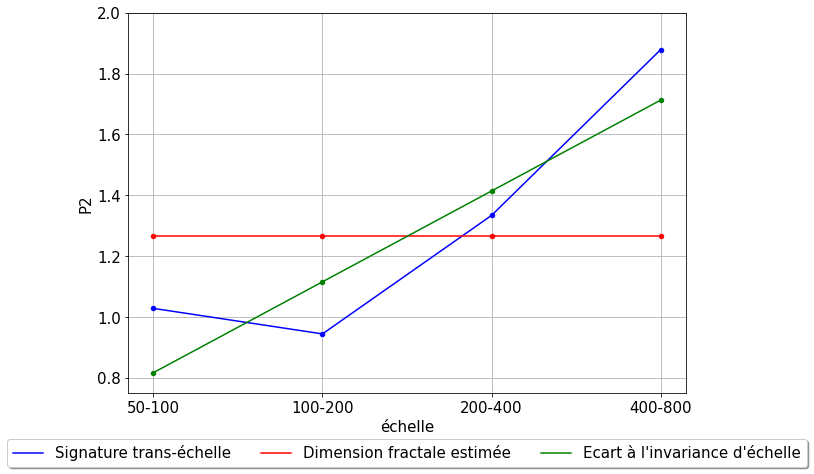

In [34]:
ax = fd_bocage.plot.scatter('échelle','Taux de Variation', figsize=(10,7), c='blue')
fd_bocage.plot.line('échelle','Taux de Variation',ax=ax, legend=False, label='Signature trans-échelle', color='blue')
fd_bocage.plot.scatter('échelle','P1',ax=ax, legend=False, label='Dimension fractale estimée', c='red')
fd_bocage.plot.line('échelle','P1',ax=ax, legend=False, label='Dimension fractale estimée', color='red')
fd_bocage.plot.scatter('échelle','P2',ax=ax, legend=False, label='Dimension fractale estimée', c='green')
fd_bocage.plot.line('échelle','P2',ax=ax, legend=False, label="Ecart à l'invariance d'échelle", color='green')
ax.set_ylim((0.75,2))

plt.legend( loc='lower right', borderaxespad=0.)
plt.grid(which='both')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.1),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('figure7_11a.pdf', format='pdf')


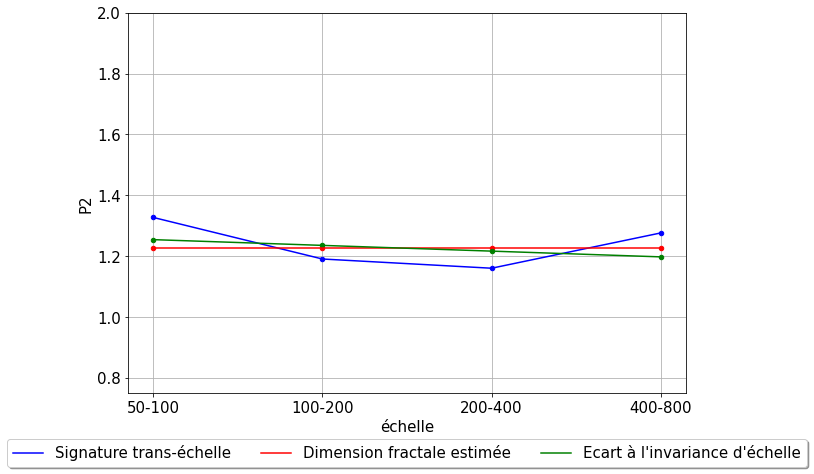

In [35]:
ax = fd_openfield.plot.scatter('échelle','Taux de Variation', figsize=(10,7), c='blue')
fd_openfield.plot.line('échelle','Taux de Variation',ax=ax, legend=False, label='Signature trans-échelle', color='blue')
fd_openfield.plot.line('échelle','P1',ax=ax, legend=False, label='Dimension fractale estimée', color='red')
fd_openfield.plot.line('échelle','P2',ax=ax, legend=False, label="Ecart à l'invariance d'échelle", color='green')
fd_openfield.plot.scatter('échelle','P1',ax=ax, legend=False, c='red')
fd_openfield.plot.scatter('échelle','P2',ax=ax, legend=False, c='green')

plt.legend( loc='lower right', borderaxespad=0.)
plt.grid(which='both')
ax.set_ylim((0.75,2))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.1),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('figure7_11b.pdf', format='pdf')